# Dense Neural Network Poker Hand

INSTITUTO FEDERAL DE MINAS GERIAS Departamento de Engenharia e Computação

Professor: Ciniro Nametala

Aluno: Euler Gomes

# 1. Ambient preparation

In [34]:
from IPython.display import display, HTML

display(HTML("<style>.container {widht: 100% !important;}</style>"))

## 1.1. Import packages

In [35]:
import subprocess
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## 1.2. Export requirements.txt

In [36]:
def export_requirements():
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                capture_output=True,
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)
        print('requirements.txt file generated successfully.')
    except subprocess.CalledProcessError as e:
        print('error:', e)


export_requirements()

requirements.txt file generated successfully.


## 1.3. Gpu check

In [37]:
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow found GPUs: {len(gpus) > 0}")
print(f"TensorFlow GPU devices: {gpus}")

TensorFlow found GPUs: True
TensorFlow GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Load dataset

In [38]:
#load dataset
data = pd.read_csv('data/poker_hand_dataset.csv')

#get columns names
col_names = data.columns.values.tolist()

data.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


# 3. Explore data

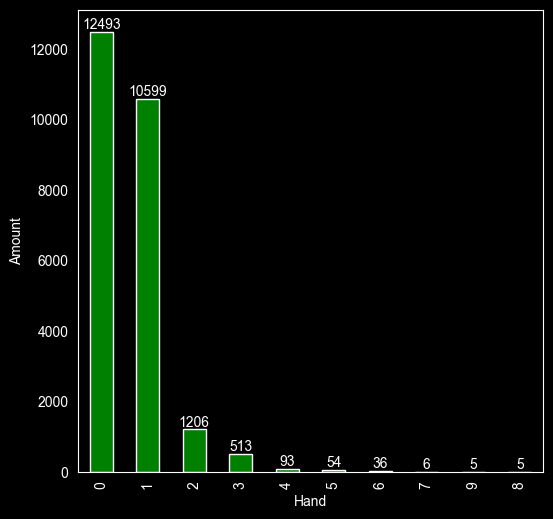

In [39]:
class_counts = data['class'].value_counts()

plt.figure(figsize=(6, 6))
class_counts.plot(kind="bar", color="green")
plt.xlabel("Hand")
plt.ylabel('Amount')
plt.grid(False)

for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

## 3.1. Summarization

In [40]:
def summarization(data):
    stats = []

    for column in col_names[0:9]:
        values = data[column]

        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Column', 'Max', 'Min', 'Mena', 'Median', 'Std']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)


summarization(data)

| Column   |   Max |   Min |   Mena |   Median |   Std |
|:---------|------:|------:|-------:|---------:|------:|
| s1       |     4 |     1 |   2.51 |        3 |  1.12 |
| c1       |    13 |     1 |   7    |        7 |  3.75 |
| s2       |     4 |     1 |   2.5  |        2 |  1.12 |
| c2       |    13 |     1 |   7.01 |        7 |  3.77 |
| s3       |     4 |     1 |   2.51 |        3 |  1.12 |
| c3       |    13 |     1 |   7.01 |        7 |  3.74 |
| s4       |     4 |     1 |   2.5  |        2 |  1.12 |
| c4       |    13 |     1 |   6.94 |        7 |  3.75 |
| s5       |     4 |     1 |   2.5  |        3 |  1.12 |


In [41]:
#split x and y from data
x_raw = data.drop('class', axis=1)
y_raw = data['class']

# 4. Pre-processing I (One-Hot Encoding for inputs)

## 4.1. Separate  suits and cards

In [42]:
suits = x_raw[['s1','s2','s3','s4','s5']]
cards = x_raw[['c1','c2','c3','c4','c5']]

## 4.2. One-Hot for suits

In [46]:
ohe_suits = OneHotEncoder(sparse_output=False)
suits_encoded = ohe_suits.fit_transform(suits)

suits_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

## 4.3. One-Hot for cards

In [47]:
ohe_cards = OneHotEncoder(sparse_output=False)
cards_encoded = ohe_suits.fit_transform(cards)

cards_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 4.4. Concatenate both

In [50]:
x = np.hstack([suits_encoded, cards_encoded])
x.shape

(25010, 85)

# 5. Pre-processing II (One-Hot Encoding for outputs)

In [56]:
y = tf.keras.utils.to_categorical(y_raw, num_classes=10)
y.shape

(25010, 10)